In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_driven import Plant, Cloud
from src import utils

from src.constants import (As, Bs) # system model
from src.constants import (T, KEY_RANGE, NUM_DATA_SETS, 
                       EPSILON_RANGE, INPUT_RANGE,
                         INITIAL_STATE_RANGE, DIST_RANGE)
            

In [2]:
def print_experiment_parameters():
    """
    Prints the system and experiment parameters.
    """
    print(f"Trajectory length for generating data: {T}")
    print(f"Input range for the system: {INPUT_RANGE}")
    print(f"Initial state range for the system: {INITIAL_STATE_RANGE}")
    print(f"Key range for random matrices F1 and G1: {KEY_RANGE}")
    print(f"Disturbance range: {DIST_RANGE}")
    print(f"Number of data sets: {NUM_DATA_SETS}")



# System and experiment parameters
print_experiment_parameters()





Trajectory length for generating data: 20
Input range for the system: 5
Initial state range for the system: 2.5
Key range for random matrices F1 and G1: 1
Disturbance range: [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]
Number of data sets: 1000


In [3]:
# initializing plant and cloud 
plant = Plant(As, Bs)
cloud = Cloud()

n = plant.num_states # number of states
m = plant.num_inputs # number of inputs

In [4]:
def run_entire_experiment():
    disturbance_epsilon_results = np.zeros((NUM_DATA_SETS, len(DIST_RANGE)))

    for dis_num, disturbance_bound in enumerate(DIST_RANGE):

        epsilon_results = np.zeros((len(EPSILON_RANGE), NUM_DATA_SETS)) 

        for iteration in range(NUM_DATA_SETS):

            # what we do
            X1, X0, U0, D0 = plant.collecting_trajectories( 
                                    T, INPUT_RANGE, INITIAL_STATE_RANGE,
                                      disturbance_bound)
            F1, G1 = plant.key_generation(n, m, KEY_RANGE)

            X1_tilde, X0_tilde, V0 = plant.transforming_data(X1, X0, U0,
                                                                     F1, G1)



            # what Cloud does   
            bA, bB, bC, bQ = cloud.ellipsoid_parameters(X1_tilde, X0_tilde,
                                                                V0, disturbance_bound)

            for ep, epsilon in enumerate(EPSILON_RANGE):

                try:
                    prob, P, Y = cloud.get_controller_cvxpy(bA, bB,
                                                                    bC, epsilon)
                    if prob.status == "infeasible":
                        epsilon_results[[ep], [iteration]] = -1
                    else:
                        epsilon_results[[ep], [iteration]] = epsilon
                except:
                    epsilon_results[[ep], [iteration]] = -1



        disturbance_epsilon_results[:,[dis_num]] = \
                np.max(epsilon_results, axis=0).reshape(-1,1)

    # save the results for future
    np.savez(data_path,
                disturbance_epsilon_results = disturbance_epsilon_results,
                max_of_disturbance = DIST_RANGE,
                num_data_sets = NUM_DATA_SETS
                )
    # return the results 
    sim_data = {'disturbance_epsilon_results':disturbance_epsilon_results,
                'max_of_disturbance':DIST_RANGE,
                'num_data_sets':NUM_DATA_SETS}
    return sim_data

In [5]:
data_path = f"data_input_range_{INPUT_RANGE}_initial_state_range_{INITIAL_STATE_RANGE}.npz"

try:
    sim_data = np.load(data_path)
    print("Using the previous results")

except:
    print("Running fresh experiments")
    sim_data = run_entire_experiment()



bins = [0, 0.010, 0.020, 0.030, 0.040, 0.050, 0.060, 0.070, 0.080, 0.090, 0.10]
df, df_epsbar_dmax = utils.processing_results(sim_data, bins)



Using the previous results


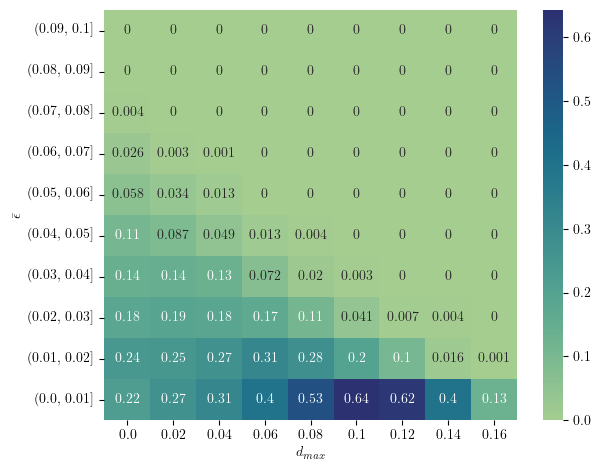

In [6]:
# plotting the results


mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

fig, ax = plt.subplots()
ax = sns.heatmap(df_epsbar_dmax, annot=True, cmap="crest")
ax.set(xlabel=r"$d_{max}$", ylabel=r"$\bar{\epsilon}$")
plt.tight_layout()

fig.savefig("epsbar_dmax_probing.pdf", transparent=True)

